In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


In [2]:
import pandas as pd

In [3]:
# air passenger data
air_df = pd.read_csv(home+'AirPassengers.csv')
air_df.columns = ['Date','Number of Passengers'] # rename columns for convenience
air_df.index = pd.DatetimeIndex(air_df['Date']) # create a time index
air_df.drop(columns=['Date'], inplace=True)
air_df.head()

,Number of Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
type(air_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Date'>

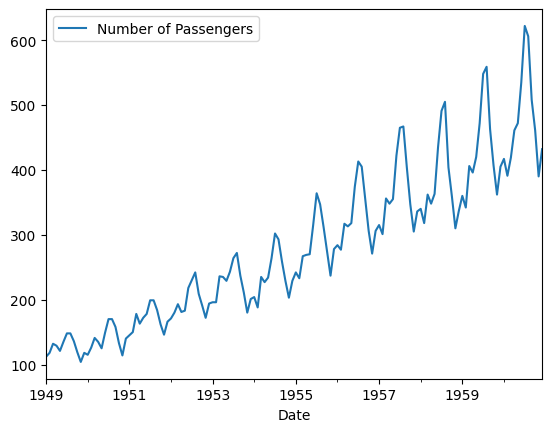

In [5]:
air_df.plot()

# Forecasting

[source](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/),
[source](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)

# Trend Forecasting

In [6]:
air_trend_df = air_df[['Number of Passengers']].rolling(12, min_periods=1).mean()

<Axes: xlabel='Date'>

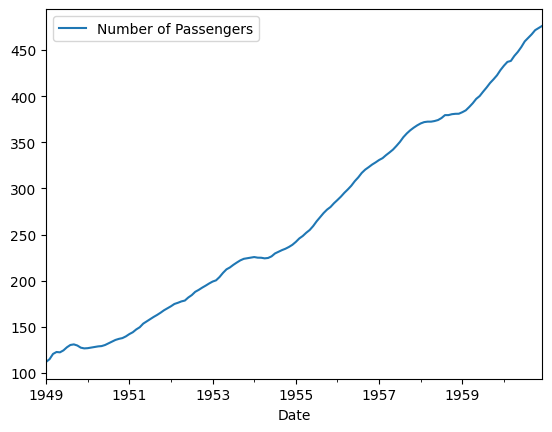

In [7]:
air_trend_df.plot()

We can't do linear regression with Pandas' DatetimeIndex objects as the independent.  Or for that matter, we cannot do linear regression with the original date string data.  Therefore, we create a new variable called days which simply **counts the number of days** from the start of the model data.  That new variable will become our independent variable as a proxy for the DatetimeIndex obects.  This is often called **feature engineering**.

In [8]:
model_df = air_trend_df.copy()
model_df['Days'] = list((model_df.index - model_df.index[0]).days)
model_df.head()

,Number of Passengers,Days
Date,,
1949-01-01,112.000000,0
1949-02-01,115.000000,31
1949-03-01,120.666667,59
1949-04-01,122.750000,90
1949-05-01,122.400000,120


In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(model_df[['Days']],model_df['Number of Passengers'])


LinearRegression()

<Axes: xlabel='Date'>

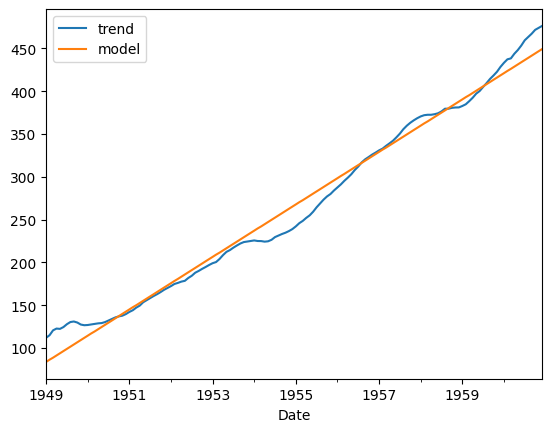

In [10]:
# visualize the fit
plot_df = pd.DataFrame({'trend':model_df['Number of Passengers'],
                        'model':model.predict(model_df[['Days']])})
plot_df.plot()

In [11]:
# compute the R^2 score
model.score(model_df[['Days']],model_df['Number of Passengers'])

0.9831801674640726

You might ask, why did we not do a linear regression on the original time series?  Surely, the linear regression would have fitted the overarching trend like so,

In [12]:
model_df2 = air_df.copy()
model_df2['Days'] = list((model_df2.index - model_df2.index[0]).days)
model_df2.head()

,Number of Passengers,Days
Date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120


In [13]:
model2 = LinearRegression()
model2.fit(model_df2[['Days']],model_df2['Number of Passengers'])


LinearRegression()

<Axes: xlabel='Date'>

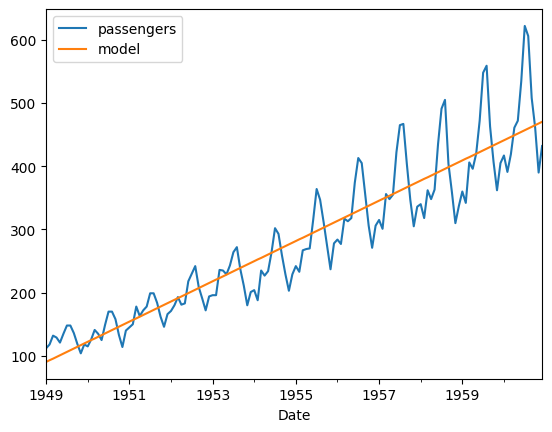

In [14]:
plot_df2 = pd.DataFrame({'passengers':model_df2['Number of Passengers'],
                        'model':model2.predict(model_df2[['Days']])})
plot_df2.plot()

Ok, looks reasonable.  But here comes the big problem, the seasonal changes introduce large residuals and therefore we have a difficult time to ascertain how good our model acutally is with respect to the trend,

In [15]:
# compute the R^2 score
model2.score(model_df2[['Days']],model_df2['Number of Passengers'])

0.8535045786367348

Looks good, but the $R^2$ score of our actual trend model was 0.98 and therefore an indicator that that model truly modeled the trend.

# Time Series Forecasting

## ARIMA

First we will use ARIMA (Autoregressive Integrated Moving Averages) models.  More precisely we will be using seaonal autoregressive integrated moving averages models or SARIMA due to the strong seaonal component in our time series.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
model3 = SARIMAX(
    air_df['Number of Passengers'],
    order=(1, 1, 0), # differenced model
    seasonal_order=(0,1,0,12) # differenced seasonal model with period 12
)
fitted_model = model3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: >

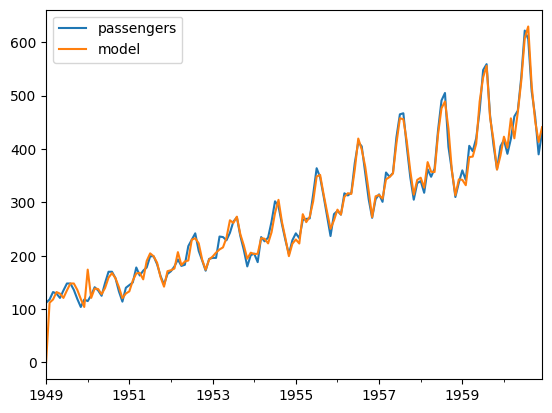

In [18]:
plot_df3 = pd.DataFrame({
    'passengers':air_df['Number of Passengers'],
    'model':fitted_model.predict()
})

plot_df3.plot()

The standard error metric for time series forecasts is the **mean absolute error** (MAE).  Let's compute it here.

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(plot_df3['passengers'],plot_df3['model'])

10.192828092301717

Let's compare this error to the error of the linear regression model we constructed earlier.

<Axes: xlabel='Date'>

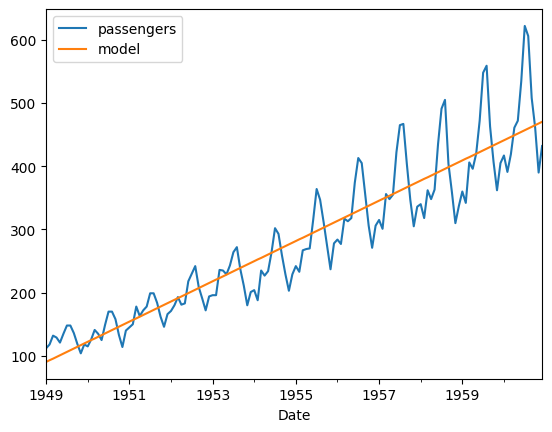

In [21]:
plot_df2.plot()

In [22]:
mean_absolute_error(plot_df2['passengers'],plot_df2['model'])

34.421954520312084

## Gradient Boosting Regressor

Let's apply a machine learning model to this problem.  We use the gradient boosting regressor from sklearn.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
model_df2.head()

,Number of Passengers,Days
Date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120


In [25]:
# we use the data we engineered for the linear regression
# as training data for our GBR
model4 = GradientBoostingRegressor(n_estimators=200)
model4.fit(model_df2[['Days']],model_df2['Number of Passengers'])


GradientBoostingRegressor(n_estimators=200)

<Axes: xlabel='Date'>

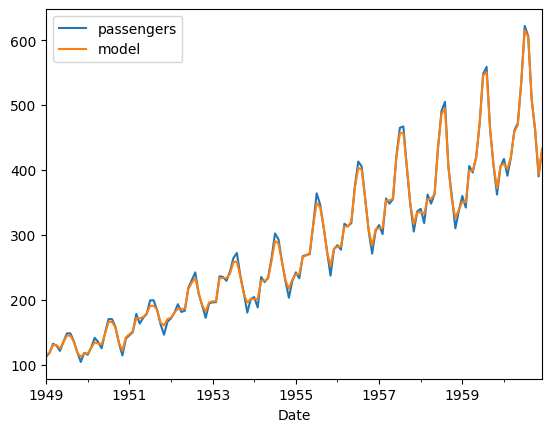

In [26]:
plot_df4 = pd.DataFrame({'passengers':model_df2['Number of Passengers'],
                         'model':model4.predict(model_df2[['Days']])})
plot_df4.plot()

In [27]:
mean_absolute_error(plot_df4['passengers'],plot_df4['model'])

4.210777271817534